In [1]:
import warnings

def no_warning(*args, **kwargs):
    pass

warnings.warn = no_warning  # 모든 경고 무력화

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from IPython.display import display
from pprint import pprint
import os
import sys

# brainbox / iblatlas / ONE 관련
from brainbox.io.one import SessionLoader, SpikeSortingLoader
from brainbox.singlecell import bin_spikes
from iblatlas.atlas import AllenAtlas
from one.api import ONE

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
print(f"BASE_DIR: {BASE_DIR}")

RESULT_DIR = os.path.join(BASE_DIR, 'result', 'VISp', 'lateralization')

def add_module_paths(base, *rel_paths):
    for rel_path in rel_paths:
        sys.path.append(os.path.join(base, *rel_path))

add_module_paths(BASE_DIR,
    ['func'],               # func 바로 아래 함수들
    ['func', 'compute'],
    ['func', 'info'],
    ['func', 'plot']
)

from print_cluster_info import print_cluster_info
from get_trial_masks import get_trial_masks
from compute_raster import compute_raster
from compute_psth import compute_psth
from plot_raster import plot_raster
from plot_psth_2x2 import plot_psth_2x2
from plot_psth_contrast import plot_psth_contrast
from plot_psth_1 import plot_psth_left_vs_right
from sub_func import save_file


BASE_DIR: c:\Users\miasc\SCH\shinlab\IBL\VISp_PSTH


In [3]:
# -----------------------------------------------------------------------------
# 1. ONE 초기화 및 인설션 검색(유연한 brain_acronym)
# -----------------------------------------------------------------------------
# 원하는 뇌영역 문자열을 지정(예: 'VISp', 'MOs' 등)

one = ONE()

insertions_dict = {}

for brain_acronym in ['VISp', 'VISl', 'VISal', 'VISam', 'VISpm', 'VISrl']:
    insertions = one.search_insertions(atlas_acronym=brain_acronym) # probe 기준으로 search 됨
    insertions_dict[brain_acronym] = list(set(insertions)) # 중복 제거
    print(f"\n[{brain_acronym}] Detected insertions: {len(set(insertions))}") 

# 겹치는 인설션들만 찾기
insertions_VISp_VISl = set(insertions_dict['VISp']).intersection(set(insertions_dict['VISl']))
print(f"\n🔍 {len(insertions_VISp_VISl)} insertions found in both VISp and VISl regions.")
insertions_VISp_VISpm = set(insertions_dict['VISp']).intersection(set(insertions_dict['VISpm']))
print(f"\n🔍 {len(insertions_VISp_VISpm)} insertions found in both VISp and VISpm regions.")
insertions_VISal_VISp_VISrl = set(insertions_dict['VISal']).intersection(set(insertions_dict['VISp'])).intersection(set(insertions_dict['VISrl']))
print(f"\n🔍 {len(insertions_VISal_VISp_VISrl)} insertions found in VISal, VISp, and VISrl regions.")



[VISp] Detected insertions: 73

[VISl] Detected insertions: 15

[VISal] Detected insertions: 5

[VISam] Detected insertions: 35

[VISpm] Detected insertions: 29

[VISrl] Detected insertions: 9

🔍 5 insertions found in both VISp and VISl regions.

🔍 11 insertions found in both VISp and VISpm regions.

🔍 1 insertions found in VISal, VISp, and VISrl regions.


<Figure size 1200x600 with 0 Axes>

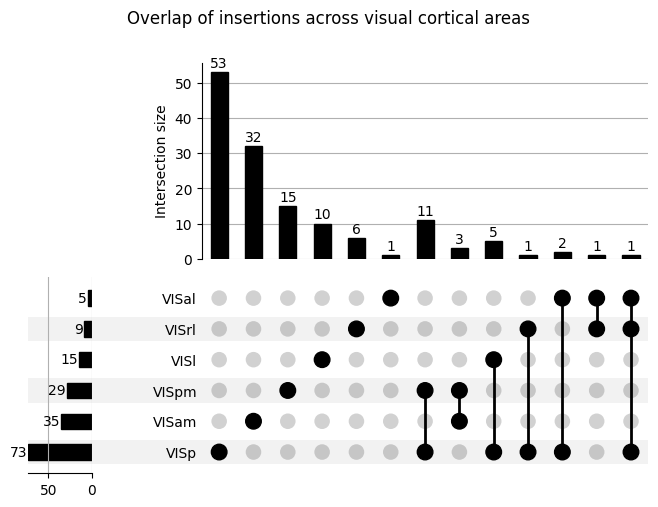

In [4]:
from upsetplot import UpSet, from_memberships
import matplotlib.pyplot as plt

# 각 인설션이 어떤 영역에 포함되는지 추적
from collections import defaultdict

insertion_to_areas = defaultdict(set)
for area, insertion_ids in insertions_dict.items():
    for sid in list(insertion_ids):  # Lazy 객체라면 list 변환
        insertion_to_areas[sid].add(area)

# 인설션별 포함 관계 → UpSet용 데이터로 변환
memberships = [tuple(sorted(areas)) for areas in insertion_to_areas.values()]
data = from_memberships(memberships)

# 시각화
plt.figure(figsize=(12, 6))
UpSet(data, subset_size='count', show_counts=True).plot()
plt.suptitle("Overlap of insertions across visual cortical areas")
plt.show()


In [5]:
# insertion_dict 내 insertion들을 모두 합쳐서, 중복 값이 존재하는지 여부 확인

from collections import defaultdict, Counter

# (1) 인설션 ID를 영역별로 추적
insertion_to_regions = defaultdict(set)

for region, insertion_list in insertions_dict.items():
    for insertion in list(insertion_list):  # <- Lazy 객체를 명시적으로 리스트로 변환
        insertion_to_regions[insertion].add(region)

# (2) 등장 횟수 세기
insertions_counts = Counter()

for insertions in insertions_dict.values():
    insertions_counts.update(list(insertions))  # <- 여기도 변환 필요

# (3) 중복 인설션 + 해당 영역 출력
duplicate_insertions = {sess for sess, count in insertions_counts.items() if count > 1}

if duplicate_insertions:
    print(f"🔁 중복된 인설션이 {len(duplicate_insertions)}개 있습니다:\n")
    for ins in sorted(duplicate_insertions):
        regions = sorted(insertion_to_regions[ins])
        print(f"- 인설션 {ins} ➜ 영역들: {', '.join(regions)}")
else:
    print("✅ 중복된 인설션은 없습니다.")

# insertions_dict: { 'VISp': [...], 'VISal': [...], ... } 형태

# 모든 pid를 하나의 리스트로 모으기
insertions = []
for pid_list in insertions_dict.values():
    insertions.extend(pid_list)

insertions = list(set(insertions)) # 중복 제거
print(f"총 {len(insertions)}개의 unique insertion PID가 수집되었습니다.")

# insertions = insertions[:5]
pprint(insertions)

🔁 중복된 인설션이 24개 있습니다:

- 인설션 0393f34c-a2bd-4c01-99c9-f6b4ec6e786d ➜ 영역들: VISam, VISpm
- 인설션 0a0184b3-9e1a-4c36-98f4-00ae3beb8f01 ➜ 영역들: VISl, VISp
- 인설션 12c0f3a9-518e-4dac-9651-5d95c2b4730f ➜ 영역들: VISl, VISp
- 인설션 18d316bf-d322-4c5c-814e-a58147f7bf5f ➜ 영역들: VISal, VISp
- 인설션 220bca21-4cf8-43f1-a213-71645899c571 ➜ 영역들: VISp, VISrl
- 인설션 478de1ce-d7e7-4221-9365-2abdc6e88fb6 ➜ 영역들: VISp, VISpm
- 인설션 4836a465-c691-4852-a0b1-dcd2b1ce38a1 ➜ 영역들: VISp, VISpm
- 인설션 5246af08-0730-40f7-83de-29b5d62b9b6d ➜ 영역들: VISam, VISpm
- 인설션 5544da75-8d34-47cb-9092-1f91e713e79c ➜ 영역들: VISal, VISp, VISrl
- 인설션 69f42a9c-095d-4a25-bca8-61a9869871d3 ➜ 영역들: VISam, VISpm
- 인설션 7f3dddf8-637f-47bb-a7b7-e303277b2107 ➜ 영역들: VISp, VISpm
- 인설션 85bdeae3-269b-4e39-bd9b-2b0d95aff2fa ➜ 영역들: VISl, VISp
- 인설션 9e069684-a4be-4b70-b9e6-446309f977d4 ➜ 영역들: VISal, VISrl
- 인설션 a6fe3779-2b77-4b66-a625-a6078720e412 ➜ 영역들: VISp, VISpm
- 인설션 a8a59fc3-a658-4db4-b5e8-09f1e4df03fd ➜ 영역들: VISp, VISpm
- 인설션 afecbc7f-10e3-40af-b091-cca9e8df61

In [6]:
i = 1

for pid in insertions:

    # Spike Sorting 데이터
    ssl = SpikeSortingLoader(one=one, pid=pid, atlas=AllenAtlas())
    spikes, clusters, channels = ssl.load_spike_sorting()
    clusters = ssl.merge_clusters(spikes, clusters, channels)
    clusters = pd.DataFrame(clusters)

    # -----------------------------------------------------------------------------
    # 클러스터 정보 출력
    # ----------------------------------------------------------------------------- 
    print(f"\nNo. of clusters from probe {i}: {len(clusters)}")
    unique_acronyms = np.unique(clusters['acronym'])
    print(f"\n🧠 probe {i} covers : \n{unique_acronyms}\n")

    print("   [[[   Cluster Info   ]]]")
    clusters_good = {k: v[clusters['label'] == 1] for k, v in clusters.items()} # Good clusters만 추출
    print_cluster_info(clusters, clusters_good)
    i += 1


No. of clusters from probe 1: 1333

🧠 probe 1 covers : 
['ICe' 'MB' 'P' 'P5' 'PB' 'POST' 'PPN' 'SUT' 'VISp4' 'VISp5' 'VISp6a'
 'bic' 'll' 'scp']

   [[[   Cluster Info   ]]]

No. of clusters in the session (good | all): [143 | 1333]

No. of clusters in each region:
ICe: 0 | 64
MB: 10 | 62
P: 7 | 36
P5: 9 | 56
PB: 59 | 481
POST: 0 | 12
PPN: 36 | 250
SUT: 16 | 237
VISp4: 1 | 17
VISp5: 0 | 37
VISp6a: 3 | 41
bic: 0 | 3
ll: 2 | 30
scp: 0 | 7

No. of clusters from probe 2: 911

🧠 probe 2 covers : 
['MB' 'MRN' 'RN' 'RSPagl6a' 'RSPd6a' 'RSPv1' 'RSPv2/3' 'RSPv5' 'RSPv6a'
 'SCdg' 'SCig' 'SCiw' 'SCop' 'SCsg' 'rust' 'void']

   [[[   Cluster Info   ]]]

No. of clusters in the session (good | all): [189 | 911]

No. of clusters in each region:
MB: 1 | 11
MRN: 76 | 283
RN: 29 | 119
RSPagl6a: 0 | 1
RSPd6a: 0 | 2
RSPv1: 3 | 17
RSPv2/3: 7 | 50
RSPv5: 0 | 19
RSPv6a: 0 | 3
SCdg: 15 | 76
SCig: 10 | 101
SCiw: 35 | 143
SCop: 3 | 27
SCsg: 10 | 54
rust: 0 | 4
void: 0 | 1

No. of clusters from probe 3: 1402

🧠

(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS055\2021-05-02\001\alf\probe00\pykilosort\#2024-05-06#\spikes.amps.npy: 100%|██████████| 154M/154M [00:33<00:00, 4.57MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS055\2021-05-02\001\alf\probe00\pykilosort\#2024-05-06#\spikes.clusters.npy: 100%|██████████| 77.2M/77.2M [00:45<00:00, 1.69MB/s]
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS055\2021-05-02\001\alf\probe00\pykilosort\#2024-05-06#\spikes.depths.npy: 100%|██████████| 154M/154M [00:41<00:00, 3.75MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS055\2021-05-02\001\alf\probe00\pykilosort\#2024-05-06#\spikes.times.npy: 100%|██████████| 154M/154M [00:31<00:00, 4.91MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS055\2021-05-02\001\alf\probe00\pykilosort\#202


No. of clusters from probe 4: 841

🧠 probe 4 covers : 
['APN' 'CA1' 'DG-mo' 'DG-po' 'DG-sg' 'LP' 'MB' 'MRN' 'VISa1' 'VISa2/3'
 'VISa4' 'VISa5' 'VISa6a' 'VISa6b' 'VISam2/3' 'bsc' 'ccs' 'or']

   [[[   Cluster Info   ]]]

No. of clusters in the session (good | all): [78 | 841]

No. of clusters in each region:
APN: 19 | 275
CA1: 3 | 85
DG-mo: 1 | 76
DG-po: 2 | 10
DG-sg: 14 | 65
LP: 0 | 1
MB: 0 | 4
MRN: 6 | 107
VISa1: 0 | 8
VISa2/3: 4 | 35
VISa4: 0 | 20
VISa5: 20 | 75
VISa6a: 6 | 52
VISa6b: 2 | 10
VISam2/3: 0 | 1
bsc: 0 | 1
ccs: 1 | 13
or: 0 | 3

No. of clusters from probe 5: 1094

🧠 probe 5 covers : 
['CA1' 'DG-mo' 'DG-sg' 'MB' 'MRN' 'SCig' 'SCiw' 'VISp5' 'VISp6a' 'VISp6b'
 'alv' 'bsc' 'fp' 'or']

   [[[   Cluster Info   ]]]

No. of clusters in the session (good | all): [138 | 1094]

No. of clusters in each region:
CA1: 24 | 202
DG-mo: 2 | 57
DG-sg: 4 | 56
MB: 8 | 93
MRN: 29 | 244
SCig: 23 | 180
SCiw: 7 | 56
VISp5: 8 | 63
VISp6a: 21 | 62
VISp6b: 3 | 9
alv: 0 | 2
bsc: 0 | 15
fp: 4 | 37
or

(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\wittenlab\Subjects\ibl_witten_29\2021-06-18\001\alf\probe01\pykilosort\#2024-05-06#\spikes.amps.npy: 100%|██████████| 256M/256M [00:45<00:00, 5.63MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\wittenlab\Subjects\ibl_witten_29\2021-06-18\001\alf\probe01\pykilosort\#2024-05-06#\spikes.clusters.npy: 100%|██████████| 128M/128M [00:41<00:00, 3.05MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\wittenlab\Subjects\ibl_witten_29\2021-06-18\001\alf\probe01\pykilosort\#2024-05-06#\spikes.depths.npy: 100%|██████████| 256M/256M [00:44<00:00, 5.75MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\wittenlab\Subjects\ibl_witten_29\2021-06-18\001\alf\probe01\pykilosort\#2024-05-06#\spikes.times.npy: 100%|██████████| 256M/256M [00:34<00:00, 7.35MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\wittenlab\Subjects\ibl_witten_29\202


No. of clusters from probe 9: 589

🧠 probe 9 covers : 
['MB' 'MRN' 'RSPagl1' 'RSPagl2/3' 'RSPagl5' 'RSPd1' 'RSPd2/3' 'RSPd5'
 'SCdg' 'SCig' 'SCiw' 'SCop' 'SCsg' 'VISpm1' 'void']

   [[[   Cluster Info   ]]]

No. of clusters in the session (good | all): [12 | 589]

No. of clusters in each region:
MB: 0 | 4
MRN: 6 | 73
RSPagl1: 0 | 3
RSPagl2/3: 0 | 46
RSPagl5: 0 | 6
RSPd1: 1 | 26
RSPd2/3: 0 | 16
RSPd5: 0 | 25
SCdg: 2 | 69
SCig: 1 | 39
SCiw: 1 | 80
SCop: 0 | 23
SCsg: 1 | 56
VISpm1: 0 | 1
void: 0 | 122

No. of clusters from probe 10: 336

🧠 probe 10 covers : 
['CA1' 'CA3' 'DG-mo' 'LGd-co' 'LGd-sh' 'TH' 'VISrl6b' 'ZI' 'alv' 'ar'
 'fiber tracts' 'fp' 'int' 'or']

   [[[   Cluster Info   ]]]

No. of clusters in the session (good | all): [41 | 336]

No. of clusters in each region:
CA1: 9 | 60
CA3: 0 | 19
DG-mo: 0 | 6
LGd-co: 11 | 58
LGd-sh: 6 | 25
TH: 0 | 1
VISrl6b: 1 | 4
ZI: 6 | 65
alv: 1 | 2
ar: 2 | 21
fiber tracts: 3 | 48
fp: 0 | 3
int: 2 | 22
or: 0 | 2

No. of clusters from probe 11: 1069

(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\danlab\Subjects\DY_013\2020-03-12\001\alf\probe00\pykilosort\#2024-05-06#\spikes.amps.npy: 100%|██████████| 166M/166M [00:39<00:00, 4.23MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\danlab\Subjects\DY_013\2020-03-12\001\alf\probe00\pykilosort\#2024-05-06#\spikes.clusters.npy: 100%|██████████| 82.9M/82.9M [00:31<00:00, 2.61MB/s]
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\danlab\Subjects\DY_013\2020-03-12\001\alf\probe00\pykilosort\#2024-05-06#\spikes.depths.npy: 100%|██████████| 166M/166M [00:40<00:00, 4.12MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\danlab\Subjects\DY_013\2020-03-12\001\alf\probe00\pykilosort\#2024-05-06#\spikes.times.npy: 100%|██████████| 166M/166M [00:41<00:00, 3.98MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\danlab\Subjects\DY_013\2020-03-12\001\alf\probe00\pykilosort\#2024-05-06#\c


No. of clusters from probe 12: 1111

🧠 probe 12 covers : 
['APN' 'CA1' 'DG-mo' 'DG-sg' 'LP' 'MRN' 'POL' 'VISp5' 'VISp6a' 'VISpm2/3'
 'VISpm4' 'VISpm5' 'VISpm6a' 'VISpm6b' 'alv' 'bsc' 'fp' 'or']

   [[[   Cluster Info   ]]]

No. of clusters in the session (good | all): [68 | 1111]

No. of clusters in each region:
APN: 42 | 709
CA1: 7 | 135
DG-mo: 0 | 10
DG-sg: 0 | 15
LP: 0 | 3
MRN: 7 | 106
POL: 0 | 6
VISp5: 1 | 4
VISp6a: 2 | 9
VISpm2/3: 1 | 28
VISpm4: 5 | 19
VISpm5: 1 | 18
VISpm6a: 0 | 10
VISpm6b: 0 | 2
alv: 0 | 8
bsc: 0 | 1
fp: 0 | 19
or: 2 | 9

No. of clusters from probe 13: 1431

🧠 probe 13 covers : 
['DG-mo' 'MB' 'MRN' 'ProS' 'RN' 'SCig' 'SCiw' 'SUB' 'VISp1' 'VISp2/3'
 'VISp4' 'VISp5' 'VISp6a' 'VISp6b' 'alv' 'bsc' 'dhc' 'fiber tracts' 'fp'
 'or' 'root']

   [[[   Cluster Info   ]]]

No. of clusters in the session (good | all): [121 | 1431]

No. of clusters in each region:
DG-mo: 0 | 19
MB: 3 | 26
MRN: 13 | 133
ProS: 27 | 202
RN: 2 | 37
SCig: 14 | 105
SCiw: 16 | 127
SUB: 14 | 181
VI

(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\wittenlab\Subjects\ibl_witten_27\2021-01-19\001\alf\probe01\pykilosort\#2024-05-06#\spikes.amps.npy: 100%|██████████| 269M/269M [01:04<00:00, 4.17MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\wittenlab\Subjects\ibl_witten_27\2021-01-19\001\alf\probe01\pykilosort\#2024-05-06#\spikes.clusters.npy: 100%|██████████| 134M/134M [00:27<00:00, 4.96MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\wittenlab\Subjects\ibl_witten_27\2021-01-19\001\alf\probe01\pykilosort\#2024-05-06#\spikes.depths.npy: 100%|██████████| 269M/269M [00:37<00:00, 7.19MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\wittenlab\Subjects\ibl_witten_27\2021-01-19\001\alf\probe01\pykilosort\#2024-05-06#\spikes.times.npy: 100%|██████████| 269M/269M [01:01<00:00, 4.36MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\wittenlab\Subjects\ibl_witten_27\202


No. of clusters from probe 17: 895

🧠 probe 17 covers : 
['APN' 'MRN' 'NOT' 'SUB' 'VISpm1' 'VISpm2/3' 'VISpm4' 'VISpm5' 'VISpm6a'
 'alv' 'dhc' 'fp' 'root' 'void']

   [[[   Cluster Info   ]]]

No. of clusters in the session (good | all): [80 | 895]

No. of clusters in each region:
APN: 22 | 221
MRN: 13 | 106
NOT: 9 | 102
SUB: 25 | 272
VISpm1: 0 | 25
VISpm2/3: 0 | 17
VISpm4: 0 | 4
VISpm5: 5 | 45
VISpm6a: 5 | 19
alv: 0 | 9
dhc: 1 | 22
fp: 0 | 14
root: 0 | 35
void: 0 | 4

No. of clusters from probe 18: 1024

🧠 probe 18 covers : 
['MB' 'MRN' 'RSPagl6a' 'RSPd5' 'RSPd6a' 'RSPv1' 'RSPv2/3' 'RSPv5' 'SCdg'
 'SCig' 'SCiw' 'SCop' 'SCsg' 'SCzo' 'VISp2/3' 'VISp4' 'VISp5' 'VISp6a'
 'void']

   [[[   Cluster Info   ]]]

No. of clusters in the session (good | all): [125 | 1024]

No. of clusters in each region:
MB: 2 | 30
MRN: 62 | 375
RSPagl6a: 4 | 25
RSPd5: 3 | 35
RSPd6a: 7 | 48
RSPv1: 0 | 6
RSPv2/3: 0 | 3
RSPv5: 0 | 11
SCdg: 14 | 90
SCig: 7 | 58
SCiw: 12 | 104
SCop: 0 | 15
SCsg: 2 | 64
SCzo: 0 | 10

(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS014\2019-12-07\001\alf\probe00\pykilosort\#2024-05-06#\spikes.amps.npy: 100%|██████████| 209M/209M [00:17<00:00, 11.9MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS014\2019-12-07\001\alf\probe00\pykilosort\#2024-05-06#\spikes.clusters.npy: 100%|██████████| 105M/105M [00:28<00:00, 3.63MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS014\2019-12-07\001\alf\probe00\pykilosort\#2024-05-06#\spikes.depths.npy: 100%|██████████| 209M/209M [00:37<00:00, 5.55MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS014\2019-12-07\001\alf\probe00\pykilosort\#2024-05-06#\spikes.times.npy: 100%|██████████| 209M/209M [00:49<00:00, 4.26MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS014\2019-12-07\001\alf\probe00\pykilosort\#2024


No. of clusters from probe 19: 790

🧠 probe 19 covers : 
['MB' 'MRN' 'POST' 'SCig' 'SCiw' 'VISp6a' 'VISp6b' 'fiber tracts' 'fp'
 'root']

   [[[   Cluster Info   ]]]

No. of clusters in the session (good | all): [97 | 790]

No. of clusters in each region:
MB: 7 | 43
MRN: 33 | 190
POST: 10 | 100
SCig: 12 | 205
SCiw: 34 | 226
VISp6a: 0 | 11
VISp6b: 0 | 2
fiber tracts: 0 | 4
fp: 1 | 5
root: 0 | 4


(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\danlab\Subjects\DY_016\2020-09-13\001\alf\probe00\pykilosort\#2024-05-06#\spikes.amps.npy: 100%|██████████| 216M/216M [00:45<00:00, 4.77MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\danlab\Subjects\DY_016\2020-09-13\001\alf\probe00\pykilosort\#2024-05-06#\spikes.clusters.npy: 100%|██████████| 108M/108M [00:29<00:00, 3.67MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\danlab\Subjects\DY_016\2020-09-13\001\alf\probe00\pykilosort\#2024-05-06#\spikes.depths.npy: 100%|██████████| 216M/216M [00:48<00:00, 4.44MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\danlab\Subjects\DY_016\2020-09-13\001\alf\probe00\pykilosort\#2024-05-06#\spikes.times.npy: 100%|██████████| 216M/216M [00:44<00:00, 4.81MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\danlab\Subjects\DY_016\2020-09-13\001\alf\probe00\pykilosort\#2024-05-06#\cl


No. of clusters from probe 20: 1077

🧠 probe 20 covers : 
['CB' 'CUL4 5' 'P' 'PAR' 'PSV' 'VISpl5' 'mcp' 'void']

   [[[   Cluster Info   ]]]

No. of clusters in the session (good | all): [61 | 1077]

No. of clusters in each region:
CB: 2 | 14
CUL4 5: 10 | 161
P: 5 | 40
PAR: 8 | 208
PSV: 28 | 558
VISpl5: 0 | 2
mcp: 6 | 51
void: 2 | 43

No. of clusters from probe 21: 723

🧠 probe 21 covers : 
['DG-mo' 'DG-po' 'DG-sg' 'ProS' 'SUB' 'VISp4' 'VISp5' 'VISp6a' 'VISp6b'
 'alv' 'dhc' 'fp' 'or']

   [[[   Cluster Info   ]]]

No. of clusters in the session (good | all): [62 | 723]

No. of clusters in each region:
DG-mo: 3 | 92
DG-po: 2 | 92
DG-sg: 10 | 100
ProS: 10 | 139
SUB: 9 | 97
VISp4: 13 | 48
VISp5: 10 | 76
VISp6a: 5 | 40
VISp6b: 0 | 2
alv: 0 | 7
dhc: 0 | 17
fp: 0 | 9
or: 0 | 4

No. of clusters from probe 22: 1094

🧠 probe 22 covers : 
['APN' 'CA1' 'DG-mo' 'DG-sg' 'LP' 'MB' 'MRN' 'MT' 'POL' 'ProS' 'VISp6a'
 'VISp6b' 'alv' 'bsc' 'fiber tracts' 'root']

   [[[   Cluster Info   ]]]

No. of clus

(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\churchlandlab\Subjects\CSHL047\2020-01-21\001\alf\probe00\pykilosort\#2024-05-06#\spikes.amps.npy: 100%|██████████| 238M/238M [00:34<00:00, 6.84MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\churchlandlab\Subjects\CSHL047\2020-01-21\001\alf\probe00\pykilosort\#2024-05-06#\spikes.clusters.npy: 100%|██████████| 119M/119M [00:35<00:00, 3.36MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\churchlandlab\Subjects\CSHL047\2020-01-21\001\alf\probe00\pykilosort\#2024-05-06#\spikes.depths.npy: 100%|██████████| 238M/238M [00:45<00:00, 5.21MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\churchlandlab\Subjects\CSHL047\2020-01-21\001\alf\probe00\pykilosort\#2024-05-06#\spikes.times.npy: 100%|██████████| 238M/238M [00:34<00:00, 6.96MB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\churchlandlab\Subjects\CSHL047\2020-01-21\00


No. of clusters from probe 24: 859

🧠 probe 24 covers : 
['APN' 'CA1' 'DG-mo' 'DG-sg' 'MB' 'MRN' 'RN' 'VISam1' 'VISam2/3' 'VISam4'
 'VISam5' 'VISpm5' 'VISpm6a' 'VISpm6b' 'alv' 'bsc' 'fp' 'or' 'void']

   [[[   Cluster Info   ]]]

No. of clusters in the session (good | all): [122 | 859]

No. of clusters in each region:
APN: 30 | 208
CA1: 13 | 182
DG-mo: 2 | 23
DG-sg: 3 | 42
MB: 1 | 9
MRN: 6 | 31
RN: 0 | 13
VISam1: 1 | 7
VISam2/3: 8 | 69
VISam4: 4 | 27
VISam5: 4 | 12
VISpm5: 36 | 115
VISpm6a: 7 | 32
VISpm6b: 0 | 6
alv: 0 | 9
bsc: 1 | 13
fp: 1 | 21
or: 5 | 19
void: 0 | 21

No. of clusters from probe 25: 829

🧠 probe 25 covers : 
['CA1' 'DG-mo' 'DG-po' 'DG-sg' 'HY' 'LGd-co' 'LP' 'MB' 'MGd' 'MGm' 'MGv'
 'SNr' 'TH' 'VISp6a' 'VISp6b' 'VISpm6a' 'ZI' 'alv' 'bsc' 'fiber tracts'
 'fp' 'or']

   [[[   Cluster Info   ]]]

No. of clusters in the session (good | all): [165 | 829]

No. of clusters in each region:
CA1: 17 | 90
DG-mo: 3 | 25
DG-po: 4 | 30
DG-sg: 6 | 43
HY: 3 | 13
LGd-co: 0 | 10
LP: 7 |

(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS045\2020-12-09\001\alf\probe01\pykilosort\spikes.amps.npy: 100%|██████████| 38.2M/38.2M [00:19<00:00, 2.01MB/s]
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS045\2020-12-09\001\alf\probe01\pykilosort\spikes.clusters.npy: 100%|██████████| 19.1M/19.1M [00:19<00:00, 965kB/s] 
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS045\2020-12-09\001\alf\probe01\pykilosort\spikes.depths.npy: 100%|██████████| 38.2M/38.2M [00:14<00:00, 2.72MB/s]
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS045\2020-12-09\001\alf\probe01\pykilosort\spikes.times.npy: 100%|██████████| 38.2M/38.2M [00:14<00:00, 2.68MB/s]
(S3) C:\Users\miasc\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS045\2020-12-09\001\alf\probe01\pykilosort\clusters.channels.npy: 100%|██████████| 2.37k/2.37k [


No. of clusters from probe 28: 280

🧠 probe 28 covers : 
['APN' 'CA1' 'DG-mo' 'DG-sg' 'MB' 'VISpm1' 'VISpm2/3' 'VISpm4' 'VISpm5'
 'VISpm6a' 'bsc' 'fp' 'or']

   [[[   Cluster Info   ]]]

No. of clusters in the session (good | all): [26 | 280]

No. of clusters in each region:
APN: 7 | 67
CA1: 3 | 57
DG-mo: 2 | 25
DG-sg: 0 | 7
MB: 1 | 16
VISpm1: 0 | 2
VISpm2/3: 2 | 17
VISpm4: 1 | 11
VISpm5: 9 | 50
VISpm6a: 0 | 19
bsc: 0 | 2
fp: 0 | 1
or: 1 | 6

No. of clusters from probe 29: 0


KeyError: 'acronym'

In [ ]:
# -----------------------------------------------------------------------------
# 2. Trial / Spike data 로드 (SessionLoader, SpikeSortingLoader)
# -----------------------------------------------------------------------------


brain_region_list = ['VISp', 'VISl', 'VISal', 'VISpm', 'VISrl']

for brain_region, cluster_label in [(region, 'good_cluster') for region in brain_region_list]:
    print(f"\nbrain_region : {brain_region}\n")

    psth_left_list = []
    psth_right_list = []

    i = 1
    for pid in insertions_dict[region] :
        print(f"🔍 [probe {i}], pid = {pid}")
        i += 1

        # Trial 데이터
        eid, pname = one.pid2eid(pid)
        sl = SessionLoader(eid=eid, one=one)
        sl.load_trials()
        events = sl.trials['stimOn_times'].values
        left_idx, right_idx, correct_idx, incorrect_idx = get_trial_masks(sl.trials) # trial mask

        # Spike Sorting 데이터
        ssl = SpikeSortingLoader(one=one, pid=pid, atlas=AllenAtlas())
        spikes, clusters, channels = ssl.load_spike_sorting()
        clusters = ssl.merge_clusters(spikes, clusters, channels)
        clusters = pd.DataFrame(clusters)

        # -----------------------------------------------------------------------------
        # 3. 특정 영역(문자열 포함) Mask 정의 (모든 + good)
        # -----------------------------------------------------------------------------
        good_mask = (clusters['label'] == 1)

        if brain_region == 'VISp':
            region_mask = np.array(['VISp' in acr for acr in clusters['acronym']]) & ~np.array(['VISpm' in acr for acr in clusters['acronym']])
        else:
            region_mask = np.array([brain_region in acr for acr in clusters['acronym']])
        
        # selected_mask = region_mask & good_mask
        selected_mask = region_mask & good_mask
        
        # -----------------------------------------------------------------------------
        # -----------------------------------------------------------------------------
        # 6. 두 가지 경우(모든 클러스터 / good 클러스터)에 대해 동일한 분석
        # -----------------------------------------------------------------------------
        
            
        selected_cluster_ids = np.where(selected_mask)[0] # 해당되는 클러스터 ID들.
        # print(f"\n🔍 Selected cluster IDs for {brain_region} ({cluster_label}): {selected_cluster_ids}")
        if cluster_label == "Single Cluster":
            selected_cluster_ids = [selected_cluster_ids[0]]

        n_clusters = len(selected_cluster_ids)
        print(f">> {n_clusters} {cluster_label} found.")
        if n_clusters == 0:
            continue
        else:
            spike_raster, times = compute_raster(spikes, selected_cluster_ids, events, pre_time=0.6, post_time=1, bin_size=0.001)
            psth_left = gaussian_filter1d(compute_psth(spike_raster, left_idx), sigma=10)
            psth_right = gaussian_filter1d(compute_psth(spike_raster, right_idx), sigma=10)

            psth_left_list.append(psth_left)
            psth_right_list.append(psth_right)
        
                
    if len(psth_left_list + psth_right_list) == 0:
        print(f"{brain_region} : No valid spike raster found.")
        continue
    
    # (3) 배열 변환
    psth_left_list = np.array(psth_left_list)  # (npids_total, nBins)
    psth_right_list = np.array(psth_right_list)
    mean_psth_left = np.nanmean(psth_left_list, axis=0)  # shape = (nBins)
    mean_psth_right = np.nanmean(psth_right_list, axis=0)

    # =======================
    # 각 영역별 Figure 출력
    # =======================
    plt.figure(figsize=(8, 4))
    plt.plot(times, mean_psth_left, label='Left trials', alpha=0.8)
    plt.plot(times, mean_psth_right, label='Right trials', alpha=0.8)
    plt.axvline(0, color='k', linestyle='--', linewidth=1)
    plt.title(f'{brain_region} - Mean PSTH')
    plt.xlabel('Time (s)')
    plt.ylabel('Firing rate (Hz)')
    plt.legend()
    plt.tight_layout()
    plt.show()

plt.show(block=False) 
plt.close('all')
print("Done.")